# 📝 Exercise M6.04

The aim of the exercise is to get familiar with the histogram
gradient-boosting in scikit-learn. Besides, we will use this model within
a cross-validation framework in order to inspect internal parameters found
via grid-search.

We will use the California housing dataset.

In [1]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(return_X_y=True, as_frame=True)
target *= 100  # rescale the target in k$

First, create a histogram gradient boosting regressor. You can set the
trees number to be large, and configure the model to use early-stopping.

In [5]:
from sklearn.ensemble import HistGradientBoostingRegressor

hgbr = HistGradientBoostingRegressor(
    max_iter=10000,
    early_stopping=True, random_state=0)

We will use a grid-search to find some optimal parameter for this model.
In this grid-search, you should search for the following parameters:

* `max_depth: [3, 8]`;
* `max_leaf_nodes: [15, 31]`;
* `learning_rate: [0.1, 1]`.

Feel free to explore the space with additional values. Create the
grid-search providing the previous gradient boosting instance as the model.

In [7]:
from sklearn.model_selection import GridSearchCV

In [32]:
param_distributions = {
    'max_depth': [3, 8],
    'max_leaf_nodes': [15, 31],
    'learning_rate': [0.1, 1]
}

model_grid_search = GridSearchCV(
    hgbr, param_grid=param_distributions, scoring='neg_mean_absolute_error',
    n_jobs=4
)

In [20]:
accuracy = model_grid_search.score(data, target)

print(
    f"The test accuracy score is: "
    f"{-accuracy:.2f}"
)

The test accuracy score is: 24.87


Finally, we will run our experiment through cross-validation. In this regard,
define a 5-fold cross-validation. Besides, be sure to shuffle the data.
Subsequently, use the function `sklearn.model_selection.cross_validate`
to run the cross-validation. You should also set `return_estimator=True`,
so that we can investigate the inner model trained via cross-validation.

In [33]:
# Write your code here.
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold

In [35]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)

cv_results = cross_validate(
    model_grid_search, data, target,
    return_estimator=True,
    cv=cv,
    n_jobs=4,
    scoring='neg_mean_absolute_error'
)

Now that we got the cross-validation results, print out the mean and
standard deviation score.

In [36]:
print('Histogram Gradient Boosting Decision Tree')
print(
    f"Mean absolute error via cross-validation: "
    f"{-cv_results['test_score'].mean():.3f} ± "
    f"{cv_results['test_score'].std():.3f}"
)

Histogram Gradient Boosting Decision Tree
Mean absolute error via cross-validation: 30.470 ± 0.296


Then inspect the `estimator` entry of the results and check the best
parameters values. Besides, check the number of trees used by the model.

In [40]:
for estimator in cv_results['estimator']:
    print(estimator.best_params_)
    print(f" # trees: {estimator.best_estimator_.n_iter_}")

{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 31}
 # trees: 214
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
 # trees: 447
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
 # trees: 423
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 15}
 # trees: 290
{'learning_rate': 0.1, 'max_depth': 8, 'max_leaf_nodes': 31}
 # trees: 145


Inspect the results of the inner CV for each estimator of the outer CV.
Aggregate the mean test score for each parameter combination and make a box
plot of these scores.

In [41]:
import pandas as pd

index_columns = [f"param_{name}" for name in param_distributions.keys()]
columns = index_columns + ['mean_test_score']

inner_cv_results = []
for cv_idx, estimator in enumerate(cv_results['estimator']):
    search_cv_results = pd.DataFrame(estimator.cv_results_)
    search_cv_results = search_cv_results[columns].set_index(index_columns)
    search_cv_results = search_cv_results.rename(
        columns={'mean_test_score': f"CV {cv_idx}"})
    inner_cv_results.append(search_cv_results)
inner_cv_results = pd.concat(inner_cv_results, axis=1).T

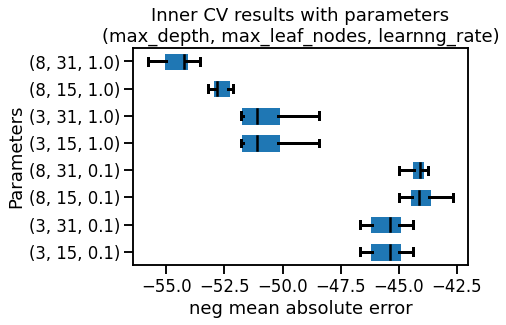

In [43]:
import matplotlib.pyplot as plt

color = {'whiskers': 'black', 'medians': 'black', 'caps': 'black'}
inner_cv_results.plot.box(vert=False, color=color)
plt.xlabel('neg mean absolute error')
plt.ylabel('Parameters')
_ = plt.title("Inner CV results with parameters\n"
              "(max_depth, max_leaf_nodes, learnng_rate)")

In [44]:
inner_cv_results

param_max_depth               3                     8                     3  \
param_max_leaf_nodes         15         31         15         31         15   
param_learning_rate         0.1        0.1        0.1        0.1        1.0   
CV 0                 -45.363795 -45.363795 -44.418063 -44.024151 -51.784022   
CV 1                 -44.983669 -44.983669 -42.684050 -44.082431 -48.438538   
CV 2                 -44.371186 -44.371186 -43.708911 -44.348723 -51.082222   
CV 3                 -46.687255 -46.687255 -44.976488 -44.980240 -51.690035   
CV 4                 -46.133727 -46.133727 -44.111906 -43.745421 -50.199512   

param_max_depth                          8             
param_max_leaf_nodes         31         15         31  
param_learning_rate         1.0        1.0        1.0  
CV 0                 -51.784022 -52.357514 -55.777035  
CV 1                 -48.438538 -52.913829 -54.148831  
CV 2                 -51.082222 -52.824518 -54.231546  
CV 3                 -51.690035 -52.151477 -54.995510  
CV 4                 -50.199512 -53.214412 -53.559586